# Examples

Let's start by importing the {py:class}`quatorch.Quaternion` class:

In [21]:
from quatorch import Quaternion

There are two main ways to initialize a quaternion: 
- from four scalars representing WXYZ components
- from a tensor that has shape $(..., 4)$

Here are two ways to define a $45$-degree rotation around the X axis:

In [22]:
import torch


# Create a quaternion from four scalars (W, X, Y, Z)
q = Quaternion(0.9239, 0.3827, 0.0, 0.0)

# Or from a tensor of shape (..., 4)
q2 = Quaternion(torch.tensor([0.9239, 0.3827, 0.0, 0.0]))

print(f"{(q == q2) = }")

(q == q2) = tensor([True, True, True, True])


Both methods create the same quaternion. Notice that element-wise comparison was performed, as a quaternion is still a subclass of `torch.Tensor`. Let's inspect some  quaternion operations as multiplication and exponentiation:

In [23]:
q = q.normalize()

print(f"{q*q*q*q             = }")
print(f"{q**4                = }")
print(f"{(4 * q.log()).exp() = }")
print(f"{-q**(-4)            = }")

q*q*q*q             = Quaternion([-2.9832e-05,  1.0000e+00,  0.0000e+00,  0.0000e+00])
q**4                = Quaternion([-2.9846e-05,  1.0000e+00,  0.0000e+00,  0.0000e+00])
(4 * q.log()).exp() = Quaternion([-2.9846e-05,  1.0000e+00,  0.0000e+00,  0.0000e+00])
-q**(-4)            = Quaternion([2.9846e-05, 1.0000e+00, 0.0000e+00, 0.0000e+00])


As expected, all the above returned the same result, which represents a 180 degrees rotation around the X axis. We can verify that by converting it to an axis-angle representation:

In [24]:
axis, angle = (q**4).to_axis_angle()
print(f"Axis: {axis}, Angle (degrees): {angle.rad2deg()}")


Axis: tensor([1.0000, 0.0000, 0.0000]), Angle (degrees): 180.00341796875


Or a rotation matrix:

In [25]:
q.to_rotation_matrix()

tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071, -0.7071],
        [ 0.0000,  0.7071,  0.7071]])

<div class="admonition tip">
<div class="title">Tip</div>
 <p> You may also construct quaternions from rotation matrices or an axis-angle representation using the methods {any}`quatorch.Quaternion.from_rotation_matrix` and {any}`quatorch.Quaternion.from_axis_angle` </p>
</div>


One interesting property of quaternions is that they take value on a 4D hyper-sphere. This means that we can interpolate between two quaternions using spherical linear interpolation ({any}`quatorch.Quaternion.slerp`). Let's see how it works:

In [26]:
q_final = q**4
t = 1/3  # interpolation parameter in [0, 1]

q.slerp(q_final, t)

Quaternion([0.7071, 0.7071, 0.0000, 0.0000])

Notice that this (and all other operations documented in the [API reference](project:api.md)) supports broadcasting. Thus, we can work with batches of quaternions seamlessly. In the example above, let's use `t` as a tensor of shape (4, 1) to get a batch of interpolated quaternions:

In [27]:
t = torch.linspace(0, 1, steps=4).unsqueeze(-1)

q.slerp(q_final, t)

Quaternion([[ 9.2388e-01,  3.8269e-01,  0.0000e+00,  0.0000e+00],
            [ 7.0710e-01,  7.0712e-01,  0.0000e+00,  0.0000e+00],
            [ 3.8266e-01,  9.2389e-01,  0.0000e+00,  0.0000e+00],
            [-2.9862e-05,  1.0000e+00,  0.0000e+00,  0.0000e+00]])

Finally let's use this batch of quaternions to rotate a vector:

In [28]:
t = torch.linspace(0, 1, steps=10).unsqueeze(-1)

batch_q = q.slerp(q_final, t)
batch_q.rotate_vector(torch.tensor([1.0, 0.0, 0.0])) 

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000]])

Unfortunately, rotating $[1, 0, 0]$ around the X axis does not change it. Let's try with another vector:

In [29]:
rotated_vectors = batch_q.rotate_vector(torch.tensor([0.0, 1.0, -1.0]))

To better illustrate it, let's plot the projection of these vectors on the YZ plane, to visualize the rotation:

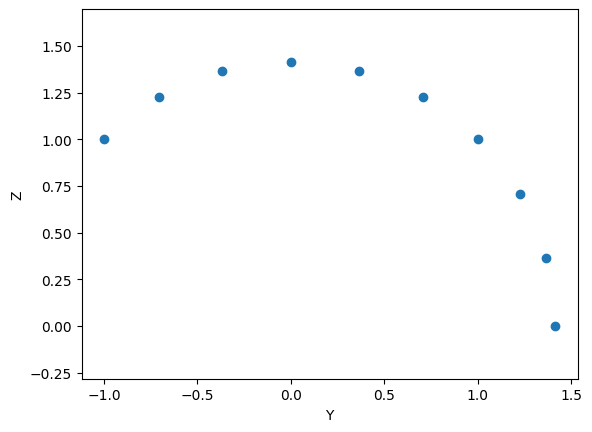

In [30]:
from matplotlib import pyplot as plt
plt.scatter(rotated_vectors[:,1], rotated_vectors[:,2])
plt.axis('equal')
plt.xlabel("Y")
plt.ylabel("Z")
plt.show()